In [19]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import importlib as imp
import torch
import warnings
warnings.simplefilter('ignore')

## Dataset (males lastnames)
About ~9k lastnames

In [20]:
with open('datasets/russian_names.txt') as input_file:
    names = input_file.read()[3:-1].split('\n')
    names = [' ' + line for line in names]

In [21]:
names[:10]

[' Abaev',
 ' Abagyan',
 ' Abaidulin',
 ' Abaidullin',
 ' Abaimoff',
 ' Abaimov',
 ' Abakeliya',
 ' Abakovsky',
 ' Abakshin',
 ' Abakumoff']

Name length ditribution

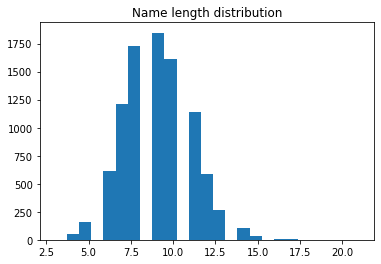

In [22]:
plt.title('Name length distribution')
plt.hist(list(map(len, names)), bins=25);

## Preprocessing

In [23]:
#all unique characters go here
tokens     = list(set(''.join(names)))
num_tokens = len(tokens)
MAX_LENGTH = max(map(len, names))
print ('num_tokens = ', num_tokens)

num_tokens =  51


### Character -> id

In [24]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [25]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [26]:
from utils import train
train = imp.reload(train)

#Example: cast 4 names to matrices, pad with zeros
print('\n'.join(names[::2000]))
print(train.to_matrix(names[::2000], token_to_id))

 Abaev
 Chihanchin
 Isakov
 Nakhamkis
 Utugunov
[[ 5. 28. 25. 19. 13.  6.  5.  5.  5.  5.  5.]
 [ 5. 40. 16. 46. 16. 19.  1. 21. 16. 46.  1.]
 [ 5. 20. 45. 19. 36. 49.  6.  5.  5.  5.  5.]
 [ 5. 11. 19. 36. 16. 19. 37. 36. 46. 45.  5.]
 [ 5.  3. 47. 26. 39. 26.  1. 49.  6.  5.  5.]]


## Echo State Network with SORM

### Create ESN instance

In [52]:
%%time
from net import esn
import importlib as imp
esn = imp.reload(esn)


device           = torch.device('cuda')
n_in             = len(tokens)
n_res            = 400
lin_size         = 64
leaking_rate     = 0.9
ro_hidden_layers = 4
spec_radius      = 0.99
density          = 0.01


net = esn.GenESN(n_in=n_in, n_res=n_res , n_out=n_in, 
                 ro_hidden_layers=ro_hidden_layers,
                 leaking_rate=leaking_rate, 
                 spec_radius=spec_radius,
                 lin_size=lin_size, 
                 density=density, 
                 device=device) 
net.to(device)
print(net)

Internal reservoir set
Reservoir has 790 non zero values (0.49%)
GenESN(
  (readout_in): Linear(in_features=400, out_features=64, bias=True)
  (readout_out): Linear(in_features=64, out_features=51, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): LogSoftmax()
)
Wall time: 2.87 s


In [53]:
lr           = 1e-3
opt          = torch.optim.Adam(net.parameters(), lr=lr)
lr_scheduler = train.scheduler(opt, patience=200)
MAX_LENGTH   = max(map(len, names))
history      = []

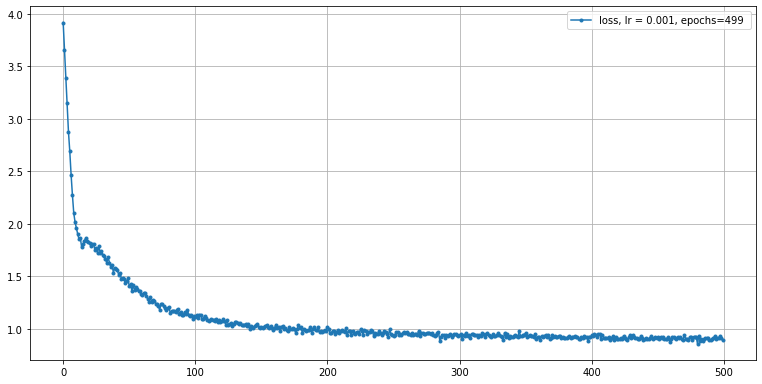

Wall time: 59.3 s


In [54]:
%%time
train = imp.reload(train)

n_epoch    = 500
batch_size = 300

train.trainESN(net, 
               data=names,
               tokens=tokens,
               token_to_id=token_to_id,
               max_length=MAX_LENGTH,
               n_epoch=n_epoch, 
               batch_size=batch_size, 
               opt=opt,
               lr_scheduler=lr_scheduler, 
               history=history)

### ESN generating

In [58]:
from utils import gen
gen = imp.reload(gen)

for _ in range(10):
    print(gen.generate_sample(net, 
                              max_length=MAX_LENGTH,
                              tokens=tokens,
                              token_to_id=token_to_id,
                              temperature=0.9, 
                              seed_phrase=' '))

 Awskin              
 Mallyanin           
 Vin                 
 Ardarken            
 Lyjhailov           
 Valukov             
 Velotov             
 Tudinchidenikov     
 Vasev               
 Mondoshen           


In [59]:
for _ in range(10):
    print(gen.generate_sample(net, 
                              max_length=MAX_LENGTH,
                              tokens=tokens,
                              token_to_id=token_to_id,
                              temperature=0.95, 
                              seed_phrase=' Alp'))

 Alpyan              
 Alpaitsov           
 Alpich              
 Alpansiyav          
 Alpilev             
 Alpovs              
 Alpelo              
 Alpalov             
 Alpakh              
 Alpaemnov           


### GridSearch Optimization hyperparams

In [117]:
from utils import optimizer
optimizer = imp.reload(optimizer)


optimizer.GridSearchOptimizer(esn.GenESN,
                              data=names,
                              n_epoch=500,
                              batch_size=300,
                              max_length=MAX_LENGTH,
                              tokens=tokens,
                              token_to_id=token_to_id,
                              in_out=(len(tokens), len(tokens)),
                              learning_rate=1e-3,
                              n_res=[300],
                              lin_size=[64, 100, 210],
                              density=[0.05, 0.1, 0.2],
                              ro_hidden_layers=[1, 2, 3],
                              leaking_rate=[0.6, 0.9])

Params: {'density': 0.05, 'leaking_rate': 0.6, 'lin_size': 64, 'n_res': 300, 'ro_hidden_layers': 1}
Internal reservoir set
Reservoir has 1692 non zero values (1.88%)
Loss function value: 0.9419999718666077 

Params: {'density': 0.05, 'leaking_rate': 0.6, 'lin_size': 64, 'n_res': 300, 'ro_hidden_layers': 2}
Internal reservoir set
Reservoir has 1447 non zero values (1.61%)
Loss function value: 0.9290000200271606 

Params: {'density': 0.05, 'leaking_rate': 0.6, 'lin_size': 64, 'n_res': 300, 'ro_hidden_layers': 3}
Internal reservoir set
Reservoir has 1574 non zero values (1.75%)
Loss function value: 0.9409999847412109 

Params: {'density': 0.05, 'leaking_rate': 0.6, 'lin_size': 100, 'n_res': 300, 'ro_hidden_layers': 1}
Internal reservoir set
Reservoir has 1593 non zero values (1.77%)
Loss function value: 0.9269999861717224 

Params: {'density': 0.05, 'leaking_rate': 0.6, 'lin_size': 100, 'n_res': 300, 'ro_hidden_layers': 2}
Internal reservoir set
Reservoir has 1571 non zero values (1.75%)


### RNN implementation

In [119]:
class CharRNNCell(nn.Module):
    
    def __init__(self, 
                 num_tokens=len(tokens), 
                 embedding_size=16, 
                 rnn_num_units=64, 
                 device = torch.device('cuda:0')):
        super(self.__class__,self).__init__()
        
        self.num_units     = rnn_num_units
        self.embedding     = nn.Embedding(num_tokens, embedding_size).to(device)
        self.rnn_update    = nn.Linear(embedding_size + rnn_num_units, rnn_num_units).to(device)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens).to(device)
        
    def forward(self, x, h_prev):
        x_emb = self.embedding(x).to(device)
        
        x_and_h = torch.cat([x_emb, h_prev], dim=1) 
        h_next  = self.rnn_update(x_and_h)         
        h_next  = F.tanh(h_next)
        
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        return Variable(torch.zeros(batch_size, self.num_units))

In [120]:
def rnn_loop(rnn, batch_index):
    batch_size, max_length = batch_index.size()
    hid_state = rnn.initial_state(batch_size).to(device)
    logprobs = []
    for x_t in batch_index.transpose(0, 1):
        hid_state, logp_next = rnn(x_t.to(device), hid_state.to(device))  
        logprobs.append(logp_next)
    return torch.stack(logprobs, dim=1)

In [127]:
def trainRNN(rnn, 
             n_epoch=500, 
             batch_size=300, 
             random_batching=True,
             max_length=MAX_LENGTH):

    for i in range(n_epoch):
        if random_batching:
            batch_ix = train.to_matrix(sample(names, batch_size), token_to_id, max_len=max_length)
            batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

            logp_seq = rnn_loop(rnn, batch_ix)

            predictions_logp   = logp_seq[:, :-1].to(device)
            actual_next_tokens = batch_ix[:, 1:].to(device)
            
            loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:, :, None]))
            loss.backward()
            opt.step()
            opt.zero_grad()

            history.append(loss.data.cpu().numpy())
            if (i + 1) % 100 == 0:
                clear_output(True)
                plt.figure(figsize=(13, 6.5))
                plt.grid()
                plt.plot(history, '.-', label='loss')
                plt.legend()
                plt.show()

    assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [128]:
char_rnn = CharRNNCell()
opt      = torch.optim.Adam(char_rnn.parameters())
history  = []

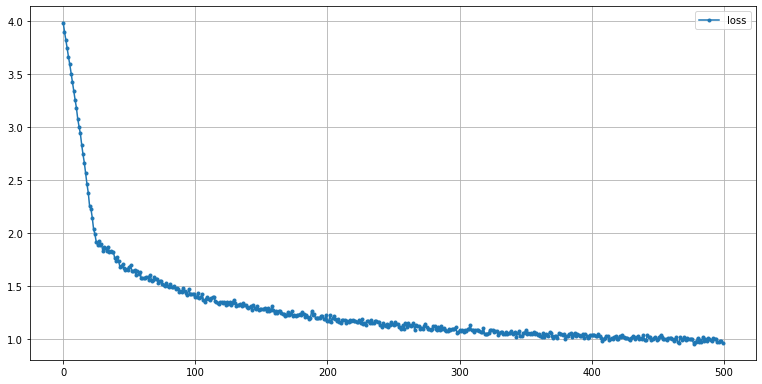

Wall time: 26 s


In [129]:
%%time
trainRNN(char_rnn, n_epoch=500, batch_size=300)

In [130]:
def generate_sample_rnn(char_rnn, 
                        seed_phrase=' ', 
                        max_length=MAX_LENGTH, 
                        temperature=1.0,
                        enforce_end=False, 
                        device=torch.device('cuda')): 
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hid_state  = char_rnn.initial_state(batch_size=1).to(device)
    
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    for _ in range(max_length - len(seed_phrase)):
        
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        
        p_next = F.softmax(logp_next / temperature, dim=-1).data.cpu().numpy()[0]
        
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        
        if enforce_end and tokens[next_ix] == ' ':
            break
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
       
        
    return ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0]])

In [133]:
for _ in range(10):
    print(generate_sample_rnn(char_rnn,temperature=0.9,seed_phrase=' Alpero'))

 Alperov             
 Alperovilov         
 Alperotan           
 Alperov             
 Alperov             
 Alperov             
 Alperovsky          
 Alperotov           
 AlperovKukov        
 Alperov             


### Evaluate and compare generated results. Vanilla RNN VS ESN

In [140]:
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
from nltk import bleu

In [141]:
n_gen = 10
t     = 0.9
rnn_generated = [generate_sample_rnn(char_rnn, 
                                     seed_phrase=' ', 
                                     temperature=t, 
                                     enforce_end=True) \
                 for x in range(n_gen)]
esn_generated = [gen.generate_sample(net, 
                                     max_length=MAX_LENGTH,
                                     tokens=tokens,
                                     token_to_id=token_to_id,
                                     seed_phrase=' ', 
                                     temperature=t, 
                                     enforce_end=True) \
                 for x in range(n_gen)]

In [142]:
rnn_generated[:3], esn_generated[:3]

([' Dharemsosshannev', ' Rardaimov', ' Polsov'],
 [' Porchin', ' Zhikov', ' Dasnko'])

In [143]:
def evaluate_gen(reference, candidates, is_sentence_bleu=False):
    sm_f      = SmoothingFunction()
    min_bleu  = 1
    score_lst = []
    for candidate in candidates:
        if is_sentence_bleu:
            score_lst.append(sentence_bleu(reference, candidate))
        else:
            score_lst.append(np.mean([bleu(ref, candidate, smoothing_function=sm_f.method1) 
                                      for ref in reference]))
    return score_lst
        

In [144]:
%time score_lst = evaluate_gen(names, esn_generated)
print('Eval mean: {:.3} Eval min: {:.3} Eval max: {:.3}'.format(np.mean(score_lst), 
                                                                min(score_lst), 
                                                                max(score_lst)))

Wall time: 24.1 s
Eval mean: 0.0371 Eval min: 0.0187 Eval max: 0.0444


In [145]:
%time score_lst = evaluate_gen(names, rnn_generated)
print('Eval mean: {:.3} Eval min: {:.3} Eval max: {:.3}'.format(np.mean(score_lst), 
                                                                min(score_lst), 
                                                                max(score_lst)))

Wall time: 26.3 s
Eval mean: 0.0335 Eval min: 0.0168 Eval max: 0.0523


In [146]:
%time score_lst = evaluate_gen(names, esn_generated, is_sentence_bleu=True)
print('Eval mean: {:.3} Eval min: {:.3} Eval max: {:.3}'.format(np.mean(score_lst), 
                                                                min(score_lst), 
                                                                max(score_lst)))

Wall time: 3.59 s
Eval mean: 0.905 Eval min: 0.669 Eval max: 1.0


In [147]:
%time score_lst = evaluate_gen(names, rnn_generated, is_sentence_bleu=True)
print('Eval mean: {:.3} Eval min: {:.3} Eval max: {:.3}'.format(np.mean(score_lst), 
                                                                min(score_lst), 
                                                                max(score_lst)))

Wall time: 3.28 s
Eval mean: 0.755 Eval min: 0.517 Eval max: 1.0


**Compare score by temperature**

In [0]:
%%time
n_gen            = 100
n_neg_sample     = 500
temperature      = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
is_sentence_bleu = True

rnn_gen_mean_lst = []
esn_gen_mean_lst = []
rnn_gen_min_lst  = []
esn_gen_min_lst  = []
rnn_gen_max_lst  = []
esn_gen_max_lst  = []

for t in temperature:
    print('Temperature {}'.format(t))
    sample_data   = sample(names, n_neg_sample)
    rnn_generated = [generate_sample_rnn(char_rnn, seed_phrase=' ', temperature=t, enforce_end=True) \
                     for x in range(n_gen)]
    score_lst = evaluate_gen(sample_data, rnn_generated, is_sentence_bleu=is_sentence_bleu)
    rnn_gen_mean_lst.append(np.mean(score_lst))
    rnn_gen_min_lst.append(min(score_lst))
    rnn_gen_max_lst.append(max(score_lst))
    
    esn_generated = [generate_sample(net, seed_phrase=' ', temperature=t, enforce_end=True) for x in range(n_gen)]
    score_lst     = evaluate_gen(sample_data, esn_generated, is_sentence_bleu=is_sentence_bleu)
    esn_gen_mean_lst.append(np.mean(score_lst))
    esn_gen_min_lst.append(min(score_lst))
    esn_gen_max_lst.append(max(score_lst))

Temperature 0.2
Temperature 0.3
Temperature 0.4
Temperature 0.5
Temperature 0.6
Temperature 0.7
Temperature 0.8
Temperature 0.9
Temperature 1
Wall time: 51.7 s


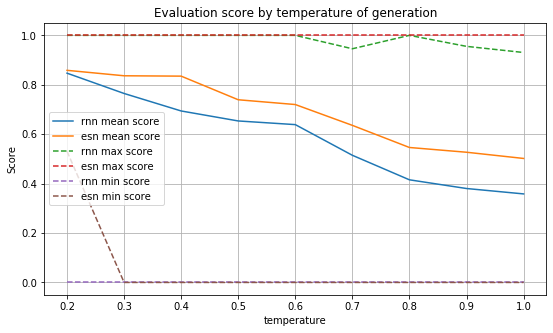

In [0]:
plt.figure(figsize=(9,5))
plt.plot(temperature, rnn_gen_mean_lst, label='rnn mean score')
plt.plot(temperature, esn_gen_mean_lst, label='esn mean score')
plt.plot(temperature, rnn_gen_max_lst, '--', label='rnn max score')
plt.plot(temperature, esn_gen_max_lst, '--', label='esn max score')
plt.plot(temperature, rnn_gen_min_lst, '--', label='rnn min score')
plt.plot(temperature, esn_gen_min_lst, '--', label='esn min score')
plt.xlabel('temperature')
plt.ylabel('Score')
plt.title('Evaluation score by temperature of generation')
plt.grid()
plt.legend()
pass

## Quotes dataset

In [61]:
%%time
import nltk
nltk.download('punkt')
import string
from nltk.tokenize import word_tokenize



with open('datasets/author_quotes.txt') as input_file:
    quotes = input_file.read()[:-1].split('\n')
    quotes = [' ' + line for line in quotes]
    
    
for i, quote in enumerate(quotes):
    
    quote      = word_tokenize(quote)
    proc_quote = []
    
    for j, token in enumerate(quote):
        
        token = list(filter(lambda char: char in list(string.ascii_letters), token))
        proc_quote.append(''.join(token))
        
    quote     = ' '.join(proc_quote)
    quotes[i] = quote.lower()


Wall time: 12.2 s


In [63]:
from random import sample
sample(quotes,5)

['my experience as a young actor on network television was that i could nt make it work  i was drowning as an actor ',
 'for some reason  the military seems more afraid of gay people than they are against terrorists  but they re very brave with the terrorists  if the terrorists ever got a hold of this information  they d get a platoon of lesbians to chase us out of baghdad ',
 'my goal is to be the best tv presenter  the best entertainer  the best singer  i still want to be the best dancer  i want to be the best at everything i do ',
 'legends die hard  they survive as truth rarely does ',
 'for i do not seek to understand in order to believe  but i believe in order to understand  for i believe this  unless i believe  i will not understand ']

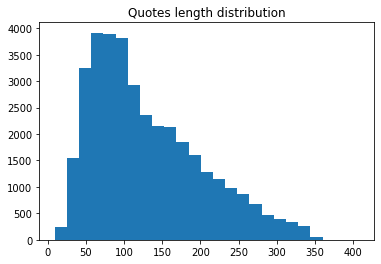

In [64]:
plt.title('Quotes length distribution')
plt.hist(list(map(len, quotes)), bins=25);

In [65]:
qtokens     = list(set(''.join(quotes)))
num_qtokens = len(qtokens)
qtoken_to_id = {token: idx for idx, token in enumerate(qtokens)}
print ('num_tokens = ', num_qtokens)

num_tokens =  27


In [67]:
assert len(qtokens) == len(qtoken_to_id), "dictionaries must have same size"
for i in range(num_qtokens):
    assert qtoken_to_id[qtokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [70]:
print('\n'.join(quotes[:1]))
print(train.to_matrix(quotes[:1], qtoken_to_id))

if you live to be a hundred  i want to live to be a hundred minus one day so i never have to live without you 
[[26.  4.  2. 18.  6. 15.  2. 22. 26.  3.  7.  2. 24.  6.  2. 16.  7.  2.
  12.  2.  9. 15.  0. 17.  1.  7. 17.  2.  2. 26.  2.  5. 12.  0. 24.  2.
  24.  6.  2. 22. 26.  3.  7.  2. 24.  6.  2. 16.  7.  2. 12.  2.  9. 15.
   0. 17.  1.  7. 17.  2. 20. 26.  0. 15. 25.  2.  6.  0.  7.  2. 17. 12.
  18.  2. 25.  6.  2. 26.  2.  0.  7.  3.  7.  1.  2.  9. 12.  3.  7.  2.
  24.  6.  2. 22. 26.  3.  7.  2.  5. 26. 24.  9.  6. 15. 24.  2. 18.  6.
  15.  2.]]


In [72]:
%%time
device           = torch.device('cuda')
n_in             = len(qtokens)
n_res            = 800
lin_size         = 30
ro_hidden_layers = 3
spec_radius      = 0.99
density          = 0.01
leaking_rate     = 1


net = esn.GenESN(n_in=n_in, n_res=n_res , n_out=n_in, 
                 ro_hidden_layers=ro_hidden_layers,
                 leaking_rate=leaking_rate, 
                 spec_radius=spec_radius,
                 lin_size=lin_size, 
                 density=density, 
                 device=device) 
net.to(device)
print(net)

Internal reservoir set
Reservoir has 2689 non zero values (0.42%)
GenESN(
  (readout_in): Linear(in_features=800, out_features=30, bias=True)
  (readout_out): Linear(in_features=30, out_features=27, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): LogSoftmax()
)
Wall time: 38 s


In [73]:
lr = 1e-2
opt = torch.optim.Adam(net.parameters(), lr=lr)
lr_scheduler = scheduler(opt, patience=200)
MAX_QLENGTH = max(map(len, quotes))
history = []

In [74]:
quotes = sorted(quotes, key=len, reverse=False)

In [75]:
len(quotes[20000])

123

In [ ]:
%%time
n_epoch    = 1500
batch_size = 200

train.trainESN(  net, data=quotes[1000:15000], 
                 n_epoch=n_epoch,
                 batch_size=batch_size, 
                 lr_scheduler=lr_scheduler, 
                 history=history, 
                 random_batching=True,
                 max_length=MAX_QLENGTH, 
                 tokens=qtokens, 
                 token_to_id=qtoken_to_id,
                 opt=opt)

In [90]:
for _ in range(7):
    print(gen.generate_sample(net, max_length=MAX_QLENGTH, 
                              tokens=qtokens,
                              token_to_id=qtoken_to_id,
                              temperature=0.7, 
                              seed_phrase=' home'))
    print()

 home is    a                                                                                                                                                                                                                                                                                                                                                                                                           

 home lothero wor do  t dongs  d                                                                                                                                                                                                                                                                                                                                                                                        

 home wor  i                                                                                                                                                                        

In [0]:
GridSearchOptimizer(data=quotes,
                    MAX_LENGTH=MAX_QLENGTH,
                    token_to_id=qtoken_to_id, 
                    tokens=qtokens, 
                    n_epoch=500, 
                    n_res=[800], 
                    in_out=(len(qtokens), len(qtokens)),
                    lin_size=[30, 50, 100], 
                    leaking_rate=[0.7, 0.8, 0.9],
                    density=[0.01], 
                    ro_hidden_layers=[2,3,4])

Params: {'density': 0.01, 'leaking_rate': 0.7, 'lin_size': 30, 'n_res': 800, 'ro_hidden_layers': 2}
internal reservoir set
Reservoir has 3088 non zero values (0.48%)
Loss function value: 0.7799999713897705 

Params: {'density': 0.01, 'leaking_rate': 0.7, 'lin_size': 30, 'n_res': 800, 'ro_hidden_layers': 3}
internal reservoir set
Reservoir has 3087 non zero values (0.48%)
Loss function value: 0.800000011920929 

Params: {'density': 0.01, 'leaking_rate': 0.7, 'lin_size': 30, 'n_res': 800, 'ro_hidden_layers': 4}
internal reservoir set
Reservoir has 3171 non zero values (0.50%)
Loss function value: 0.7960000038146973 

Params: {'density': 0.01, 'leaking_rate': 0.7, 'lin_size': 50, 'n_res': 800, 'ro_hidden_layers': 2}
internal reservoir set
Reservoir has 3115 non zero values (0.49%)
Loss function value: 0.7749999761581421 

Params: {'density': 0.01, 'leaking_rate': 0.7, 'lin_size': 50, 'n_res': 800, 'ro_hidden_layers': 3}
internal reservoir set
Reservoir has 3166 non zero values (0.49%)
Los